In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
from matplotlib import cm
import math
from scipy.integrate import cumulative_trapezoid
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd

In [10]:
def plot_fidelity_from_csv(csv_file_3Imp: str, csv_file_1Imp: str, name: str):
    """Function to plot fidelities from CSV files.
    Args:
        csv_file_3Imp (str): Path to the CSV file for 3ImpNet.
        csv_file_1Imp (str): Path to the CSV file for 1ImpNet.
        name (str): Name for saving the plot.
    """
    df_3Imp = pd.read_csv(csv_file_3Imp)
    df_1Imp = pd.read_csv(csv_file_1Imp)

    #grouping and calculating mean and std
    fids_3Imp_mean = df_3Imp.groupby("g")[['FID_J2', 'FID_JZ', 'FID_JDM', 'FID_J2Z']].mean()
    fids_3Imp_std  = df_3Imp.groupby("g")[['FID_J2', 'FID_JZ', 'FID_JDM', 'FID_J2Z']].std()

    fids_1Imp_mean = df_1Imp.groupby("g")[['FID_J2', 'FID_JZ', 'FID_JDM', 'FID_J2Z']].mean()
    fids_1Imp_std  = df_1Imp.groupby("g")[['FID_J2', 'FID_JZ', 'FID_JDM', 'FID_J2Z']].std()

    g_values = fids_3Imp_mean.index.values

    fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    parameter_names = [r'J$_2$', r'J$_\mathrm{Z}$', r'J$_\mathrm{DMI}$', r'J$_3$']
    columns = ['FID_J2', 'FID_JZ', 'FID_JDM', 'FID_J2Z']
    colors = {'MultiImp': 'blue', 'SingleImp': 'red'}
    letters = ['a)', 'b)', 'c)', 'd)']

    for i, ax in enumerate(axs.flatten()):
        col = columns[i]

        ax.scatter(g_values, fids_3Imp_mean[col],color=colors['MultiImp'])
        ax.plot(g_values, fids_3Imp_mean[col], color=colors['MultiImp'])

        ax.scatter(g_values, fids_1Imp_mean[col], color=colors['SingleImp'])
        ax.plot(g_values, fids_1Imp_mean[col], color=colors['SingleImp'])

        '''Plot with error bars'''
        ax.errorbar(g_values, fids_3Imp_mean[col], yerr=fids_3Imp_std[col],
                    label='MultiImp', color=colors['MultiImp'], capsize=3)
        ax.errorbar(g_values, fids_1Imp_mean[col], yerr=fids_1Imp_std[col],
                    label='SingleImp', color=colors['SingleImp'], capsize=3)

        ax.set_ylim(0.2, 1.03)
        ax.set_title(parameter_names[i], fontsize=25, y = 1.05)
        ax.tick_params(axis='both', which='major', labelsize=22)

        ax.text(-0.08, 1.05, letters[i], transform=ax.transAxes, ha='left', va='bottom', fontsize=25)

    axs[0, 0].set_ylabel('Fidelity', fontsize=25, x=0.05)
    axs[1, 0].set_ylabel('Fidelity', fontsize=25, x=0.05)

    axs[1, 0].set_xlabel(r'Random noise $\chi$', fontsize=25, y=0.09)
    axs[1, 1].set_xlabel(r'Random noise $\chi$', fontsize=25, y=0.09)

    handles = [plt.Line2D([0], [0], color=colors[k], lw=2, label=k) for k in colors]

    fig.legend(
        handles=handles,
        loc='lower right',
        bbox_to_anchor=(0.79, 0),  
        fontsize=23,
        ncol=2,
        frameon=True
    )

    plt.subplots_adjust(left=0.15, bottom=0.17, right=0.95, top=0.9, wspace=0.08, hspace=0.25)
    plt.savefig(f'fidelities_subplots_{name}.png', dpi=500)
    plt.show()

def plot_spectra_subplots(dcs_all: np.array, samples: list, imin: float, imax: float, n_rows: int, n_cols: int, figsize: tuple, param_names: list, name: str):
    """
    Function to plot spectra as subplots.
    Args:
        dcs_all (np.array): Array of dcs with shape (n_samples, n_dcs * n_Es).
        samples (list): List of sample indices to plot.
        imin (float): Minimum value for the color scale.
        imax (float): Maximum value for the color scale.
        n_rows (int): Number of rows in the subplot grid.
        n_cols (int): Number of columns in the subplot grid.
        figsize (tuple): Size of the figure.
        param_names (list): List of parameter names for titles.
        name (str): Name for saving the plot.
    """
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)
    
    cmap = cm.get_cmap('inferno')
    norm = mcolors.Normalize(vmin=imin, vmax=imax)

    for i, ax in enumerate(axs.flatten()):

        with open("XYZ.OUT", "w") as f:  

            '''Loop over sites'''
            for s in range(21): 
                for idx, freq in enumerate(np.linspace(-0.5, 4, 300)):
                    D = dcs_all[samples[i], s * 300 : s * 300 + 300]
                    
                    f.write(f"{s}  {freq}  {D[idx]}\n")

        '''Create mesh'''
        d = np.genfromtxt("XYZ.OUT").T  
        x = np.linspace(0, 20, 300)
        y = np.linspace(-0.5, 4, 300)
        x_mesh, y_mesh = np.meshgrid(x, y)

        z_mesh = griddata((d[0], d[1]), d[2], (x_mesh, y_mesh), method='cubic')


        mesh_plot = ax.contourf(x_mesh, y_mesh, z_mesh, 100, norm=norm, cmap=cmap)
        ax.tick_params(axis='both', which='major', labelsize=28)  
        ax.set_title(param_names[i], fontsize=28)

    axs[0, 0].set_ylabel(r'Energy [J$_1$]', fontsize=28, x=0.05)
    axs[1, 0].set_ylabel(r'Energy [J$_1$]', fontsize=28, x=0.05)

    axs[1, 0].set_xlabel('Site number', fontsize=28, y=0.09)
    axs[1, 1].set_xlabel('Site number', fontsize=28, y=0.09)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', fraction=0.05, pad=0.05, location = 'right')
    cbar.set_label(r'$S(\omega)$', fontsize=28)
    cbar.ax.tick_params(labelsize=28)

    plt.subplots_adjust(left=0.12, bottom=0.1, right=0.85, top=0.9, wspace=0.12, hspace=0.16)
    
    plt.savefig(f'heat_{name}.png', dpi=500)
    plt.show()

def include_dc(dcs_all, chain_lenght, n_dcs, n_Es, dc_dir:int):
    """
    Function to include a specific direction of dcs in the dataset.
    Args:
        dcs_all (np.array): Array of all dcs with shape (n_samples, n_dcs * n_Es).
        chain_lenght (int): Length of the spin chain.
        n_dcs (int): Number of dcs.
        n_Es (int): Number of energy values.
        dc_dir (int): Direction of the dc to include (0 to n_dcs-1).
    Returns:
        np.array: Array of dcs for the specified direction with shape (n_samples, n_Es * chain_lenght).
    """
    
    dc_dir_ALL = np.zeros((dcs_all.shape[0],n_Es*chain_lenght))
    ind_all = [] 

    for s in range(chain_lenght):
        ind = range((n_dcs*s+dc_dir)*n_Es,(n_dcs*s+dc_dir)*n_Es+n_Es)
        ind_all.append(ind)
        dc = dcs_all[:,:][:, ind]
        dc = np.squeeze(dc)
        dc_dir_ALL[:,s*n_Es:s*n_Es+n_Es] = dc

    return dc_dir_ALL


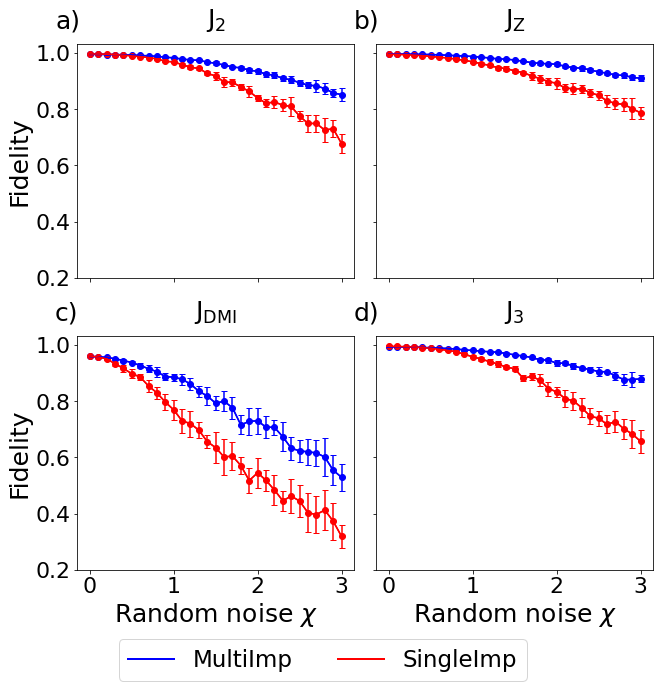

In [11]:
'''downloading the fidelity dataset with 3ImpNet and 1ImpNet'''
csv_file_3Imp = "3ImpNet.csv" 
csv_file_1Imp = "1ImpNet.csv" 
name = "Fid_3ImpNet_1ImpNet_plot_averaged"

plot_fidelity_from_csv(csv_file_3Imp, csv_file_1Imp, name)


In [12]:
'''downloading dynamical correlator dataset (x direction) with perturbation in the middle'''
dI2_d2V_data_10_dom    = np.genfromtxt(f'dI2_d2V_dominating_parameters_10.txt')
dI2_d2V_10_dcs_dom     = dI2_d2V_data_10_dom[:,:-6]                             #taking dynamical correlators only
dI2_d2V_10_params_dom  = dI2_d2V_data_10_dom[:,-6:]                             #taking parameters only

'''downloading dynamical correlator dataset (x direction) with perturbation at 8 and 12'''
dI2_d2V_data_812_dom    = np.genfromtxt(f'dI2_d2V_dominating_parameters_812.txt')
dI2_d2V_812_dcs_dom     = dI2_d2V_data_812_dom[:,:-6]
dI2_d2V_812_params_dom  = dI2_d2V_data_812_dom[:,-6:]

'''downloading dynamical correlator dataset (x direction) with perturbation at 9 and 11'''
dI2_d2V_data_911_dom    = np.genfromtxt(f'dI2_d2V_dominating_parameters_911.txt')
dI2_d2V_911_dcs_dom     = dI2_d2V_data_911_dom[:,:-6]                               
dI2_d2V_911_params_dom  = dI2_d2V_data_911_dom[:,-6:]

In [13]:
def extend_with_reversed_subsets(arr, num_of_energies):
    ''''Function to extend dynamical correlators for the whole symmetric chain.
    1. Takes an array of dynamical correlators for one half of the chain.
    2. Creates subsets of the array based on the number of energies.
    3. Reverses the subsets and concatenates them to create an extended array for the whole chain.
    4. Returns the extended array with dynamical correlators for the whole chain.
    5. The output array has dynamical correlators for the whole chain, first x and then z direction for each spin.

    Args:
        arr (np.array): Input array with shape (n_samples, n_features). Input array has dynamical correlators for one half of the chain in one spatial direction.
        num_of_energies (int): Size of the subsets to create. Grid point number in the dynamical correlators.
    Returns:
        np.array: Extended array with shape (n_samples, new_features). Output array has dynamical correlators for the whole chain'''
    
    num_cols = arr.shape[1]                
    num_spins = num_cols // num_of_energies   
    subsets = [arr[:, i*num_of_energies:(i+1)*num_of_energies] for i in range(num_spins)]     #create subset 

    reversed_subsets = subsets[:-1][::-1]                                                     #exclude last subset and reverse
    extended_dIdV = np.hstack(subsets + reversed_subsets)                                     #concatenate data

    return extended_dIdV

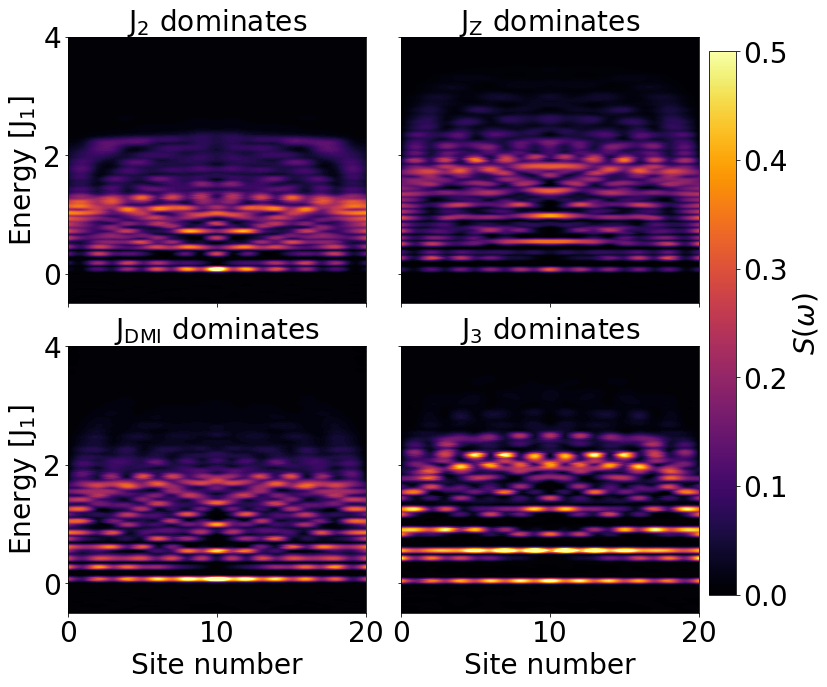

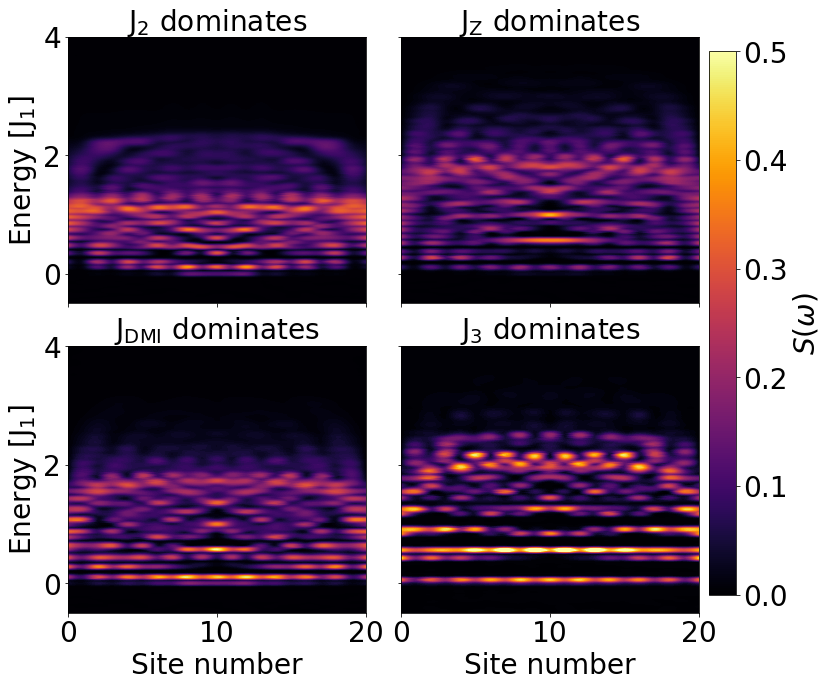

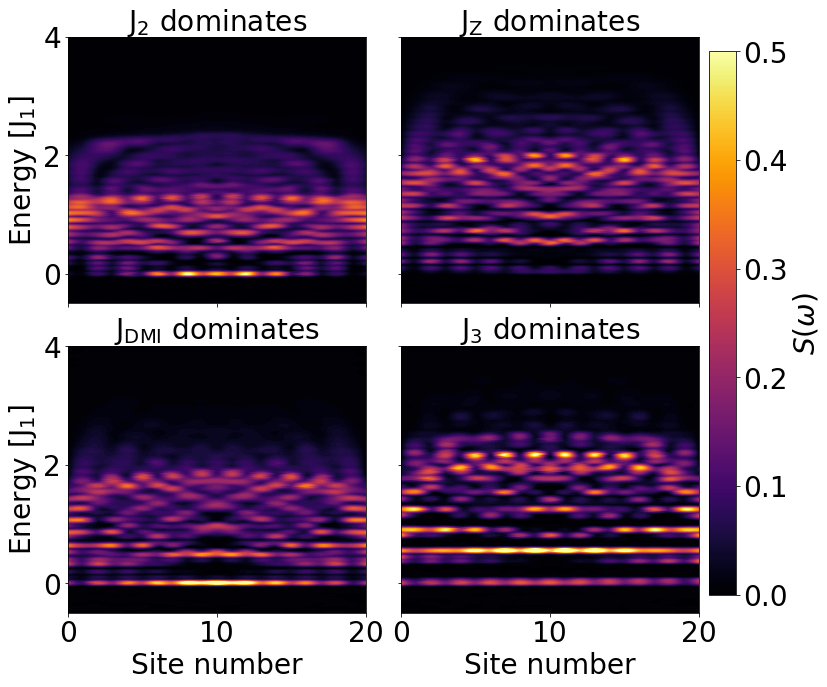

In [14]:
'''extending the dynamical correlators for the whole symmetric chain'''
dI2_d2V_10_dcs  = extend_with_reversed_subsets(dI2_d2V_10_dcs_dom, 300)         #expanding dynamical correlators for the whole chain
dI2_d2V_812_dcs = extend_with_reversed_subsets(dI2_d2V_812_dcs_dom, 300)
dI2_d2V_911_dcs = extend_with_reversed_subsets(dI2_d2V_911_dcs_dom, 300)  

'''taking example samples for plotting'''
parameter_names = [r'J$_2$ dominates', r'J$_\mathrm{Z}$ dominates', r'J$_\mathrm{DMI}$ dominates', r'J$_3$ dominates']
samples = [0, 1, 2, 3]

plot_spectra_subplots(dI2_d2V_10_dcs, samples, 0, 0.5, 2, 2, (12, 10), parameter_names, 'dominating_params_10')
plot_spectra_subplots(dI2_d2V_812_dcs, samples, 0, 0.5, 2, 2, (12, 10), parameter_names, 'dominating_params_812')
plot_spectra_subplots(dI2_d2V_911_dcs, samples, 0, 0.5, 2, 2, (12, 10), parameter_names, 'dominating_params_911')


In [15]:
def compute_fidelity(true:np.array, pred:np.array):
    """Function to compute fidelity between predicted and true values.
    Args:
        true (np.array): Array of true values.
        pred (np.array): Array of predicted values.
    Returns:
        float: Fidelity value rounded to 5 decimal places.
    """

    E_pred_true    = np.mean(np.multiply(pred, true))
    E_pred         = np.mean(pred)
    E_true         = np.mean(true)
    E_pred2        = np.mean(np.multiply(pred, pred))
    E_true2        = np.mean(np.multiply(true, true))
    
    fidelity       = abs(E_pred_true - E_pred*E_true) / math.sqrt((E_true2 - E_true**2)*(E_pred2 - E_pred**2))
    return float(format(fidelity, ".2f"))

def plot_baselines(baselines: list, name: str, chi: float, NN_name: str):
    """Function to plot baselines of predicted values compared to true values.
    Args:
        baselines (list): List of tuples containing parameter name, true values, and predicted values.
        name (str): Name for saving the plot.
        chi (float): Random noise value used in the dataset.
    """
    fig, axes = plt.subplots(nrows=2, ncols=len(baselines)//2, figsize = (10,5))
    axes = axes.flatten()

    for idx, pred in enumerate(baselines):
        axes[idx].scatter(pred[1], pred[2], c = 'blue')
        axes[idx].set_title(f'{pred[0]} [J]', fontsize=25)
        axes[idx].plot(pred[1], pred[1], color='red')
        fid = compute_fidelity(pred[2], pred[1])
        axes[idx].text(0.2, 0.8, r'$\mathcal{F}$'+ f' :{fid}', fontsize= 20, transform=axes[idx].transAxes, horizontalalignment='center', verticalalignment='center') 
        axes[idx].tick_params(axis='both', which='major', labelsize=23)
    
    fig.supxlabel('True values', fontsize=25, y=0.02)
    fig.supylabel('Predicted values', fontsize=25, x=0.05)
    fig.suptitle(rf'Predicted parameters with $\chi$={chi} for {NN_name}', fontsize=25)
    plt.subplots_adjust(left=0.17, bottom=0.18, right=0.98, top=0.82, wspace=0.35, hspace=0.66)
    plt.savefig(f'baselines_'+name+'.png', dpi = 500)
    plt.show()


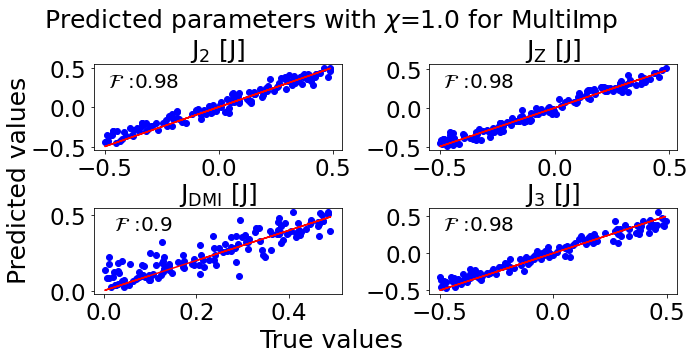

In [ ]:
'''downloading and plotting predicted results for MultiImp, chi = 1'''
predicted_MultiImp_chi1 = np.genfromtxt(f'predicted_results_3ImpNet_noisy.txt')

pred_J2_M_chi1  = predicted_MultiImp_chi1[:,0]
true_J2         = predicted_MultiImp_chi1[:,1]
pred_JZ_M_chi1  = predicted_MultiImp_chi1[:,2]
true_JZ         = predicted_MultiImp_chi1[:,3]
pred_JDM_M_chi1 = predicted_MultiImp_chi1[:,4]
true_JDM        = predicted_MultiImp_chi1[:,5]
pred_J3_M_chi1  = predicted_MultiImp_chi1[:,6]
true_J3         = predicted_MultiImp_chi1[:,7]

param_names = [r'J$_2$', r'J$_\mathrm{Z}$', r'J$_\mathrm{DMI}$', r'J$_3$']

baselines_MultiImp = [
    (param_names[0], true_J2, pred_J2_M_chi1),
    (param_names[1], true_JZ, pred_JZ_M_chi1),
    (param_names[2], true_JDM, pred_JDM_M_chi1),
    (param_names[3], true_J3, pred_J3_M_chi1)
]

plot_baselines(baselines_MultiImp, 'MultiImp_chi1', chi = 1.0, NN_name = 'MultiImp')


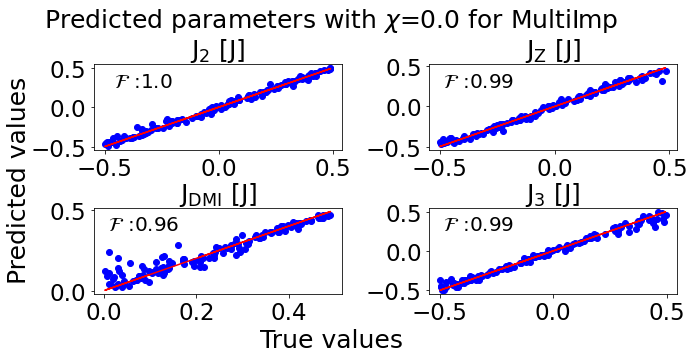

In [ ]:
'''downloading and plotting predicted results for MultiImp, chi = 0'''
predicted_MultiImp_chi0 = np.genfromtxt(f'predicted_results_3ImpNet.txt')

pred_J2_M_chi0  = predicted_MultiImp_chi0[:,0]
pred_JZ_M_chi0  = predicted_MultiImp_chi0[:,1]
pred_JDM_M_chi0 = predicted_MultiImp_chi0[:,2]
pred_J3_M_chi0  = predicted_MultiImp_chi0[:,3]

baselines_MultiImp_chi0 = [
    (param_names[0], true_J2, pred_J2_M_chi0),
    (param_names[1], true_JZ, pred_JZ_M_chi0),
    (param_names[2], true_JDM, pred_JDM_M_chi0),
    (param_names[3], true_J3, pred_J3_M_chi0)
]

plot_baselines(baselines_MultiImp_chi0, 'MultiImp_chi0', chi=0.0, NN_name='MultiImp')

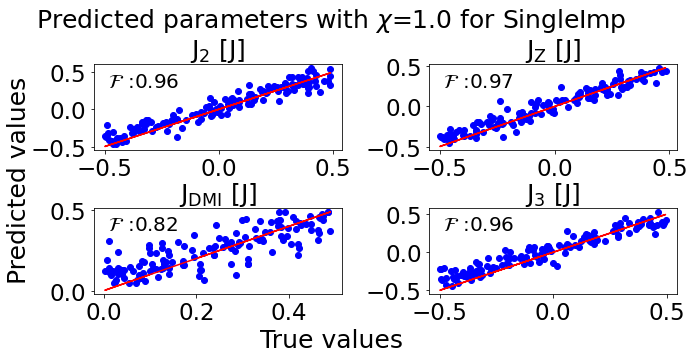

In [ ]:
'''downloading and plotting predicted results for SingleImp, chi = 1'''
predicted_SingleImp = np.genfromtxt(f'predicted_results_1ImpNet_noisy.txt')

pred_J2_S_chi1  = predicted_SingleImp[:,0]
true_J2         = predicted_SingleImp[:,1]
pred_JZ_S_chi1  = predicted_SingleImp[:,2]
true_JZ         = predicted_SingleImp[:,3]
pred_JDM_S_chi1 = predicted_SingleImp[:,4]
true_JDM        = predicted_SingleImp[:,5]
pred_J3_S_chi1  = predicted_SingleImp[:,6]
true_J3         = predicted_SingleImp[:,7]

baselines_SingleImp = [
    (param_names[0], true_J2, pred_J2_S_chi1),
    (param_names[1], true_JZ, pred_JZ_S_chi1),
    (param_names[2], true_JDM, pred_JDM_S_chi1),
    (param_names[3], true_J3, pred_J3_S_chi1)
]

plot_baselines(baselines_SingleImp, 'SingleImp_chi1', chi=1.0, NN_name ='SingleImp')



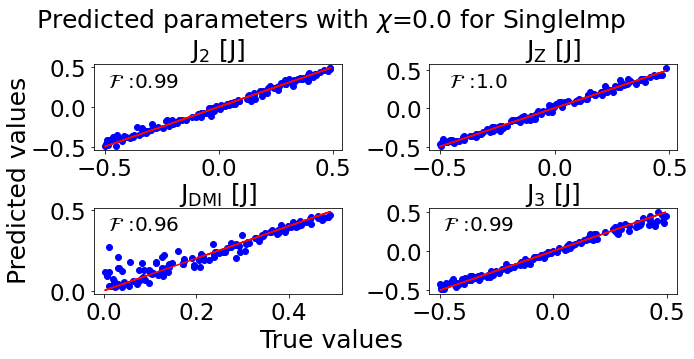

In [ ]:
'''downloading and plotting predicted results for SingleImp, chi = 0'''
predicted_SingleImp_chi0 = np.genfromtxt(f'predicted_results_1ImpNet.txt')

pred_J2_1_chi0  = predicted_SingleImp_chi0[:,0]
pred_JZ_1_chi0  = predicted_SingleImp_chi0[:,1]
pred_JDM_1_chi0 = predicted_SingleImp_chi0[:,2]
pred_J3_1_chi0  = predicted_SingleImp_chi0[:,3]

baselines_SingleImp_chi0 = [
    (param_names[0], true_J2, pred_J2_1_chi0),
    (param_names[1], true_JZ, pred_JZ_1_chi0),
    (param_names[2], true_JDM, pred_JDM_1_chi0),
    (param_names[3], true_J3, pred_J3_1_chi0)
]

plot_baselines(baselines_SingleImp_chi0, 'SingleImp_chi0', chi=0.0, NN_name='SingleImp')



In [ ]:
def plot_spectra_subplots_for_predictions(dcs_all: np.array, samples: list, imin: float, imax: float, n_rows: int, n_cols: int, figsize: tuple, name: str):
    """
    Function to plot prediction spectra as subplots.
    Args:
        dcs_all (np.array): Array of dcs with shape (n_samples, n_dcs * n_Es).
        samples (list): List of sample indices to plot.
        imin (float): Minimum value for the color scale.
        imax (float): Maximum value for the color scale.
        n_rows (int): Number of rows in the subplot grid.
        n_cols (int): Number of columns in the subplot grid.
        figsize (tuple): Size of the figure.
        name (str): Name for saving the plot.
    """
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=True, sharey=True)
    
    cmap = cm.get_cmap('inferno')
    norm = mcolors.Normalize(vmin=imin, vmax=imax)

    param_names = [r'True $S^{xx}(\omega)$', 'SingleImp $S^{xx}(\omega)$ \nReconstructed', 'MultiImp $S^{xx}(\omega)$ \nReconstructed', r'True $S^{zz}(\omega)$', 'SingleImp $S^{zz}(\omega)$ \nReconstructed', 'MultiImp $S^{zz}(\omega)$ \nReconstructed']

    for i, ax in enumerate(axs.flatten()):

        with open("XYZ.OUT", "w") as f:

            '''Loop over sites'''
            for s in range(21): 
                for idx, freq in enumerate(np.linspace(-0.5, 4, 300)):
                    D = dcs_all[samples[i], s * 300 : s * 300 + 300]
                    
                    f.write(f"{s}  {freq}  {D[idx]}\n")

        '''Create mesh'''
        d = np.genfromtxt("XYZ.OUT").T 
        x = np.linspace(0, 21 - 1, 300)
        y = np.linspace(-0.5, 4, 300)
        x_mesh, y_mesh = np.meshgrid(x, y)

        z_mesh = griddata((d[0], d[1]), d[2], (x_mesh, y_mesh), method='cubic')

        mesh_plot = ax.contourf(x_mesh, y_mesh, z_mesh, 100, norm=norm, cmap=cmap)
        ax.tick_params(axis='both', which='major', labelsize=15)  
        ax.set_title(param_names[i], fontsize=15)

    # Labels
    axs[0, 0].set_ylabel(r'Energy [J$_1$]', fontsize=15, x=0.05)
    axs[1, 0].set_ylabel(r'Energy [J$_1$]', fontsize=15, x=0.05)

    axs[1, 0].set_xlabel('Site number', fontsize=15, y=0.09)
    axs[1, 1].set_xlabel('Site number', fontsize=15, y=0.09)
    axs[1, 2].set_xlabel('Site number', fontsize=15, y=0.09)

    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', fraction=0.05, pad=0.05, location = 'right')
    cbar.set_label(r'$S(\omega)$', fontsize=15)
    cbar.ax.tick_params(labelsize=15)

    plt.subplots_adjust(left=0.12, bottom=0.1, right=0.85, top=0.9, wspace=0.1, hspace=0.2)    
    plt.savefig(f'heat_{name}.png', dpi=500, facecolor='white', transparent=False)
    plt.show()
    

In [ ]:
'''Downloading and plotting predicted dynamical correlators for MultiImp and SingleImp
Dataset has first the x direction, then z
First True correlators, then SingleImp chi = 0, chi = 1, then MultiImp chi = 0, chi = 1'''

predicted_d2IdV2_data = np.genfromtxt(f'spinchain21_predictions_with_true_dcs.txt')

d2IdV2_dcs    = predicted_d2IdV2_data[:,:-6]                   #taking dynamical correlators only
d2IdV2_params = predicted_d2IdV2_data[:, -6:]                  #taking parameters only

d2IdV2_x  = d2IdV2_dcs[:, :3300]
d2IdV2_z  = d2IdV2_dcs[:, 3300:]

extended_d2IdV2_x = extend_with_reversed_subsets(d2IdV2_x, 300)      #expanding dynamical correlators for the whole chain
extended_d2IdV2_z = extend_with_reversed_subsets(d2IdV2_z, 300)      #expanding dynamical correlators for the whole chain

pred_SingleImp_x_0 = extended_d2IdV2_x[1,:]                                #taking x direction of the predicted correlators for SingleImp
pred_SingleImp_z_0 = extended_d2IdV2_z[1,:]                                #taking z direction of the predicted correlators for SingleImp
pred_SingleImp_x_1 = extended_d2IdV2_x[3,:]                                #taking x direction of the predicted correlators for SingleImp
pred_SingleImp_z_1 = extended_d2IdV2_z[3,:]                                #taking z direction of the predicted correlators for SingleImp

pred_MultiImp_x_1 = extended_d2IdV2_x[2,:]                                 #taking x direction of the predicted correlators for MultiImp
pred_MultiImp_z_1 = extended_d2IdV2_z[2,:]                                 #taking z direction of the predicted correlators for MultiImp
pred_MultiImp_x_0 = extended_d2IdV2_x[4,:]                                 #taking x direction of the predicted correlators for MultiImp
pred_MultiImp_z_0 = extended_d2IdV2_z[4,:]                                 #taking z direction of the predicted correlators for MultiImp

true_d2IdV2_x = extended_d2IdV2_x[0,:]                                   #taking x direction of the true correlators
true_d2IdV2_z = extended_d2IdV2_z[0,:]

correlators_chi0 = np.stack((true_d2IdV2_x, pred_SingleImp_x_0, pred_MultiImp_x_0, true_d2IdV2_z, pred_SingleImp_z_0, pred_MultiImp_z_0), axis = 0)
correlators_chi1 = np.stack((true_d2IdV2_x, pred_SingleImp_x_1, pred_MultiImp_x_1, true_d2IdV2_z, pred_SingleImp_z_1, pred_MultiImp_z_1), axis = 0)



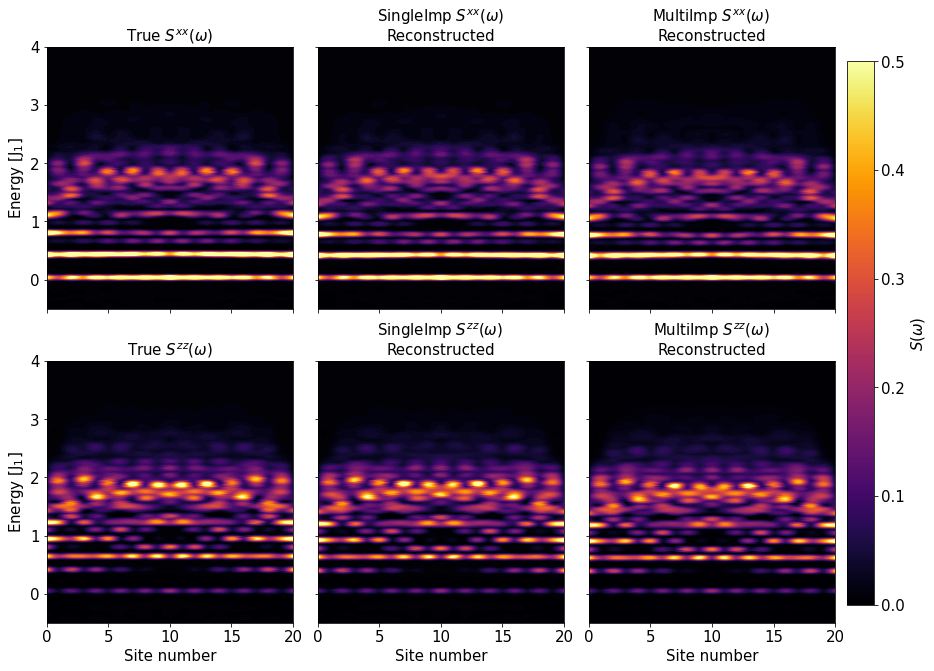

In [35]:
name = 'predicted_correlators_chi0'
plot_spectra_subplots_for_predictions(correlators_chi0, [0, 1, 2, 3, 4, 5], 0, 0.5, 2, 3, (15, 10), name)


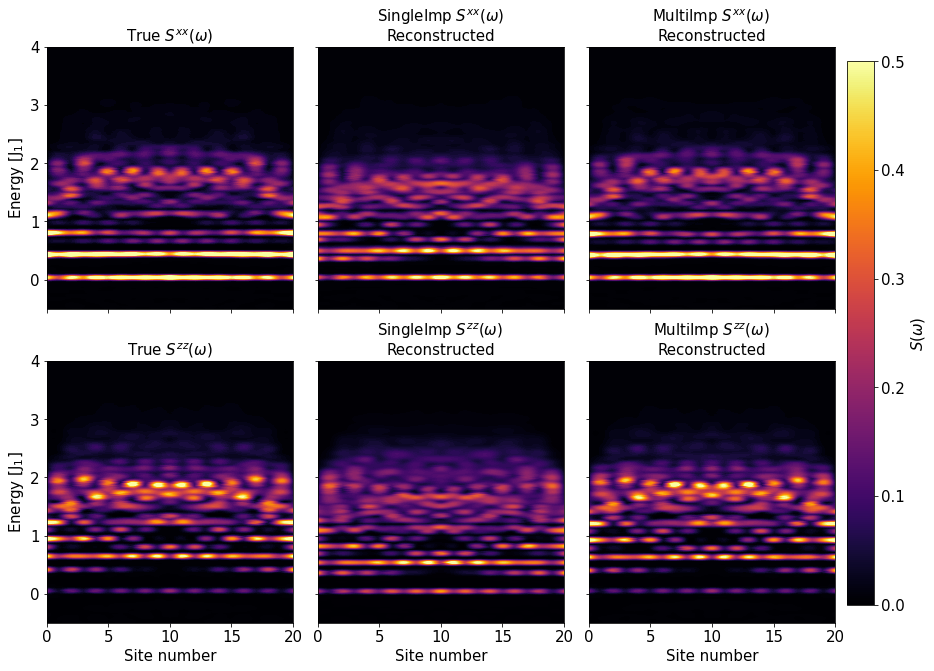

In [36]:
name= 'predicted_correlators_chi1'
plot_spectra_subplots_for_predictions(correlators_chi1, [0, 1, 2, 3, 4, 5], 0, 0.5, 2, 3, (15, 10), name)